1. CVAT 25 fullsize images
2. annotation to masks
3. augmentation

In [39]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from albumentations import (
    Crop,
    Compose,
    Transpose,
    RandomSizedCrop,
    OneOf,
    Flip,
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90
)
from tqdm import tqdm
from lxml import etree
import cv2

In [5]:
path = 'W:\\datasets\\asbestos\\line-segmentation\\'
os.listdir(path)

['images', 'macro_fullsize.xml', 'masks', 'v1']

In [6]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    
img_pathes.sort()

In [7]:
img_pathes[:3]

['W:\\datasets\\asbestos\\line-segmentation\\images\\DSC05086.jpg',
 'W:\\datasets\\asbestos\\line-segmentation\\images\\DSC05089.jpg',
 'W:\\datasets\\asbestos\\line-segmentation\\images\\DSC05090.jpg']

### 2. annotation to masks

In [8]:
anno_path = 'W:\\datasets\\asbestos\\line-segmentation\\macro_fullsize.xml'

https://github.com/opencv/cvat/blob/develop/utils/mask/converter.py

In [67]:
np.random.seed(0)

In [10]:
def parse_anno_file(cvat_xml):
    root = etree.parse(cvat_xml).getroot()
    anno = []
    for image_tag in root.iter('image'):
        image = {}
        for key, value in image_tag.items():
            image[key] = value
        image['shapes'] = []
        for poly_tag in image_tag.iter('polygon'):
            polygon = {'type': 'polygon'}
            for key, value in poly_tag.items():
                polygon[key] = value
            image['shapes'].append(polygon)

        image['shapes'].sort(key=lambda x: int(x.get('z_order', 0)))
        anno.append(image)

    return anno

In [11]:
def create_mask_file(mask_path, width, height, bitness, color_map, background, shapes):
    mask = np.full((height, width, bitness // 8), background, dtype=np.uint8)
    for shape in shapes:
        color = color_map.get(shape['label'], background)
        points = [tuple(map(float, p.split(','))) for p in shape['points'].split(';')]
        points = np.array([(int(p[0]), int(p[1])) for p in points])

        mask = cv2.fillPoly(mask, [points], color=color)
        
    cv2.imwrite(mask_path, mask)

In [12]:
def create_empty_mask_file(mask_path, width, height, bitness, color_map, background, shapes):
    mask = np.full((height, width, bitness // 8), background, dtype=np.uint8)
    cv2.imwrite(mask_path, mask)

In [13]:
anno = parse_anno_file(anno_path)

In [15]:
#anno

In [16]:
mask_folder_path = 'W:\\datasets\\asbestos\\line-segmentation\\masks\\'

In [19]:
for image in tqdm(anno, desc='Generate masks'):
    mask_path = os.path.join(mask_folder_path, os.path.splitext(image['name'])[0] + '.png')
    mask_dir = os.path.dirname(mask_path)
    if mask_dir:
        os.makedirs(mask_dir, exist_ok=True)
    create_mask_file(mask_path, int(image['width']), int(image['height']), 
                     24, {'asbestos':(255,0,0)}, (0,0,0), image['shapes'])

Generate masks: 100%|██████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.84it/s]


#### empty masks (no asbestos)

In [26]:
#img_path = 'W:\\datasets\\asbestos\\line-segmentation\\aug_images_1120\\'
#img_names = os.listdir(img_path)
#mask_path = 'W:\\datasets\\asbestos\\line-segmentation\\aug_masks_1120\\'
#mask_names = os.listdir(mask_path)

In [27]:
#path = 'W:\\datasets\\asbestos\\line-segmentation\\'
#os.listdir(path)

In [25]:
#for folder in os.listdir(path):
#    pathes = []
#    for pth, dirs, files in os.walk(os.path.join(path, folder)):
#        for file in files:
#            pathes.append(os.path.join(pth, file))
#    if folder == 'images':
#        img_pathes = pathes
#    elif folder == 'masks':
#        lbl_pathes = pathes
#        
#img_pathes.sort()
#lbl_pathes.sort()

In [24]:
#len(img_pathes), len(lbl_pathes)

In [23]:
#set_img_names = set(img_names)
#set_mask_names = set(mask_names)

In [22]:
#empty_mask_names = set_img_names - set_mask_names

In [21]:
#empty_mask_names

In [20]:
# empty masks
#mask_folder_path = 'W:\\datasets\\asbestos\\line-segmentation\\aug_masks_1120\\'
#for image in tqdm(empty_mask_names):
#    mask_path = os.path.join(mask_folder_path, image)
#    mask_dir = os.path.dirname(mask_path)
#    if mask_dir:
#        os.makedirs(mask_dir, exist_ok=True)
#    create_empty_mask_file(mask_path, 1120, 1120, 
#                     24, {'asbestos':(255,0,0)}, (0,0,0), None)

### 3. augmentation

In [28]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images':
        img_pathes = pathes
    elif folder == 'masks':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [29]:
len(img_pathes), len(lbl_pathes)

(25, 25)

In [30]:
images, masks = [], []
for i in img_pathes:
    images.append(np.asarray(Image.open(i)))
for i in lbl_pathes:
    masks.append(np.asarray(Image.open(i).convert('L')))

In [31]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

3376 6000


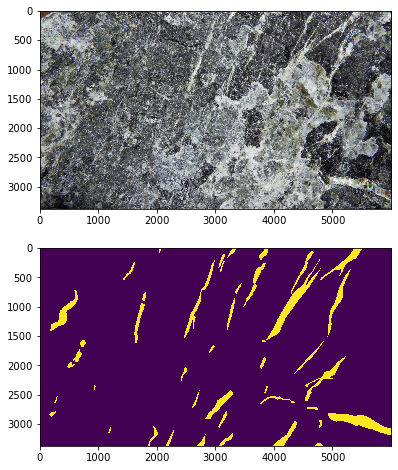

In [32]:
image = images[0]
mask = masks[0]
original_height, original_width = image.shape[:2]
print(original_height, original_width)
visualize(image, mask)

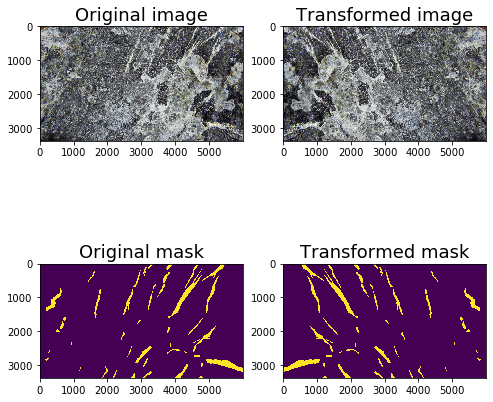

In [35]:
aug = HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

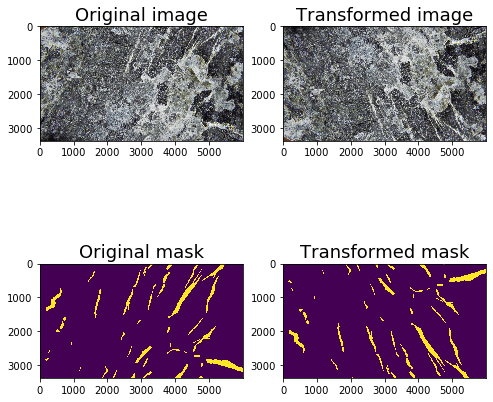

In [36]:
aug = VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

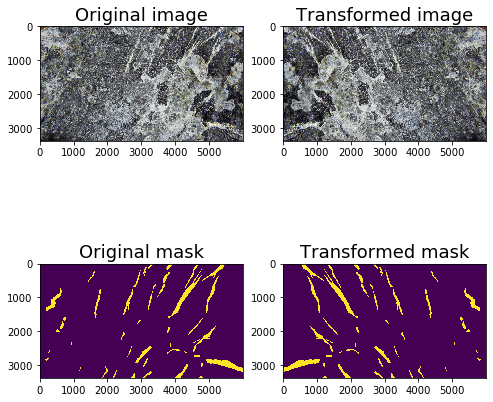

In [37]:
aug = Flip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

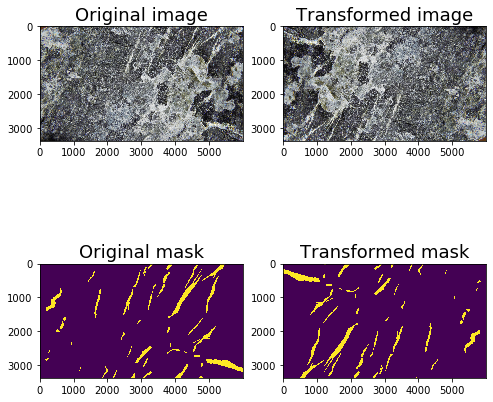

In [40]:
aug = RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)

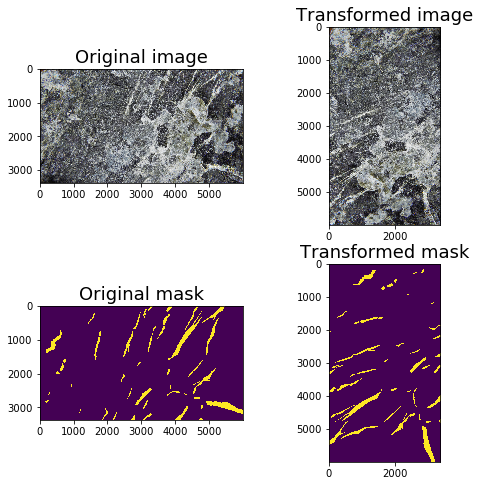

In [41]:
aug = Transpose(p=1)

augmented = aug(image=image, mask=mask)

image_transposed = augmented['image']
mask_transposed = augmented['mask']

visualize(image_transposed, mask_transposed, original_image=image, original_mask=mask)

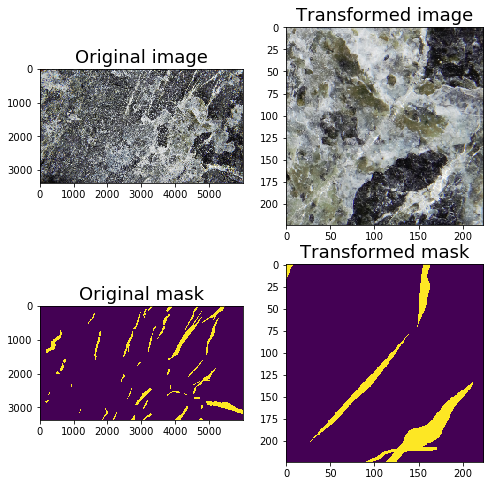

In [42]:
aug = RandomSizedCrop(p=1, min_max_height=(1120, 1120), height=224, width=224)

augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize(image_scaled, mask_scaled, original_image=image, original_mask=mask)

### Crop + Flip + Transpose + Rotate
 ? OneOf([], p=1)

In [43]:
aug = Compose([RandomSizedCrop(min_max_height=(1120, 1120), 
                           height=224, 
                           width=224, 
                           p=1),
               Flip(p=0.5),
               Transpose(p=0.5),
               RandomRotate90(p=0.5)])

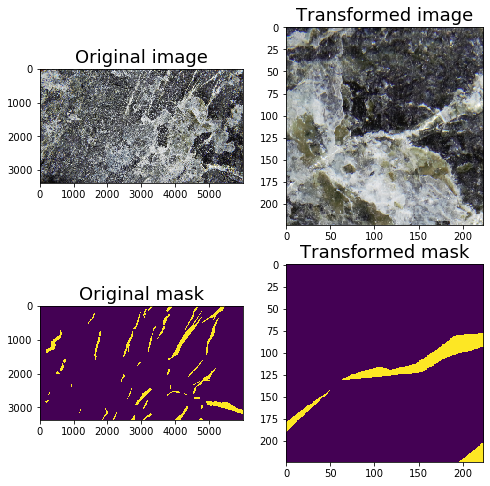

In [54]:
augmented = aug(image=image, mask=mask)

image_medium = augmented['image']
mask_medium = augmented['mask']

visualize(image_medium, mask_medium, original_image=image, original_mask=mask)

In [56]:
for i in tqdm(range(25)):
    file_mask = lbl_pathes[i].split('\\')[-1].split(".")[0]
    file_image = img_pathes[i].split('\\')[-1].split(".")[0]
    for j in range(20):
        #image, mask = images[i], masks[i]
        new_file_mask = file_mask + '_' + str(j) + '.png'
        new_file_image = file_image + '_' + str(j) + '.png'
        augmented = aug(image=images[i], mask=masks[i])
        image_medium = augmented['image']
        mask_medium = augmented['mask']
        
        result_image = Image.fromarray(image_medium)
        result_image.save('W:\\datasets\\asbestos\\line-segmentation\\aug_images_224\\' + new_file_image)
        result_mask = Image.fromarray(mask_medium)
        result_mask.save('W:\\datasets\\asbestos\\line-segmentation\\aug_masks_224\\' + new_file_mask)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.85it/s]


In [57]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'aug_images_224':
        img_pathes = pathes
    elif folder == 'aug_masks_224':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [58]:
len(img_pathes), len(lbl_pathes)

(500, 500)